In [ ]:
!pip install opendatasets

In [ ]:
# imports
import os
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import opendatasets as od
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet
import matplotlib.pyplot as plt

# Download dataset and create dataloader

In [ ]:
 od.download("https://www.kaggle.com/datasets/emilyguan2/covid-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andreacheng41
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/emilyguan2/covid-dataset


100%|██████████| 185M/185M [00:01<00:00, 128MB/s]


In [ ]:
 od.download("https://www.kaggle.com/datasets/andreacheng41/bangladesh-chestxray-dlproject")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andreacheng41
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andreacheng41/bangladesh-chestxray-dlproject


100%|██████████| 42.7M/42.7M [00:00<00:00, 99.0MB/s]


In [ ]:
 od.download("https://www.kaggle.com/datasets/emilyguan2/nigeria-only/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andreacheng41
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/emilyguan2/nigeria-only


100%|██████████| 187M/187M [00:01<00:00, 142MB/s]


In [ ]:
 od.download("https://www.kaggle.com/datasets/mahdiopra/rsua-chest-x-ray-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: andreacheng41
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mahdiopra/rsua-chest-x-ray-dataset


100%|██████████| 109M/109M [00:01<00:00, 71.4MB/s] 


In [ ]:
class CXRDataset(Dataset):
    def __init__(self, path, folder_mapping, sub_folder=None, transform=None):
        """
        Args:
            folder_mapping (dict): A dictionary where keys are target labels and values are lists of folder paths.
                                   Example: {"Normal": ["path_to_Normal_folder"],
                                             "Non-Pneumonia Disease": ["path_to_COVID", "path_to_Lung_Opacity"],
                                             "Pneumonia": ["path_to_Viral_Pneumonia"]}
            transform (callable, optional): Optional transforms to be applied on an image.
            use_SRM_IL (boolean): Indicates use of SRM IL perturbations on an image.
        """
        self.data = []
        self.labels = []
        self.transform = transform

        # Load all images and assign corresponding labels
        for label, folders in folder_mapping.items():
            for folder in folders:
                folder_path = os.path.join(path, folder)
                if sub_folder:
                    folder_path = os.path.join(folder_path, sub_folder)

                for file_name in os.listdir(folder_path):
                    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Filter image files
                        img_path = os.path.join(folder_path, file_name)
                        self.data.append(img_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
          image = self.transform(image)

        return image, torch.tensor(label)


## Create Datasets for Different Baselines

* A: Covid-19
* B: Nigeria
* C: Bangladesh
* D: Indonesia

In [ ]:
# Define transforms (same as before)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


a_dir = "covid-dataset"
b_dir = "nigeria-only"
c_dir = "bangladesh-chestxray-dlproject"
d_dir = "rsua-chest-x-ray-dataset/RSUA Chest X-Ray Dataset/Data Chest X-Ray RSUA (Annotated)-20230618T030427Z-001/Data Chest X-Ray RSUA (Annotated)"


a_folder_map = {
    0: ["A_normal_sample"],
    1: ["A_other_sample"],
    2: ["A_pn_sample"]
}



b_folder_map = {
    0: ["nigeria_normal/nigeria_normal"],
    1: ["nigeria_other/nigeria_other"],
    2: ["nigeria_pneumonia/nigeria_pneumonia"]
}

c_folder_map = {
    0: ["Normal"],
    1: ["COVID", "Lung_Opacity"],
    2: ["Viral Pneumonia"]
}

d_folder_map = {
    0: [ "Non_Covid/images"],
    1: ["Covid/images"],
    2: [ "Non_Covid_Pneumonia/images"]
}

a_dataset = CXRDataset(a_dir, a_folder_map, transform=transform)
b_dataset = CXRDataset(b_dir, b_folder_map, transform=transform)
c_dataset = CXRDataset(c_dir, c_folder_map, transform=transform)
d_dataset = CXRDataset(d_dir, d_folder_map, transform=transform)



In [ ]:
print([len(a_dataset), len(b_dataset), len(c_dataset), len(d_dataset)])

[5200, 1951, 4350, 371]


## Control Types

* Positive control: train on domains A, B, C, D, val on domain C, test on D
* Negative control: train on A, B, val on C, test on D

In [ ]:
# Define dataset sizes
dataset_AB = ConcatDataset([a_dataset, b_dataset])

dataset_AB_size = len(dataset_AB)
dataset_C_size = len(c_dataset)
dataset_D_size = len(d_dataset)

pos_C_size = 1350
pos_D_size = 150
pos_AB_size = dataset_AB_size - pos_C_size - pos_D_size

c_include, pos_val_dataset = random_split(c_dataset, [pos_C_size, dataset_C_size - pos_C_size])
d_include, pos_test_dataset = random_split(d_dataset, [pos_D_size, dataset_D_size - pos_D_size])
ab_include, _ = random_split(dataset_AB, [pos_AB_size, dataset_AB_size - pos_AB_size])


pos_train_dataset = ConcatDataset([ab_include, c_include, d_include])


# Create positive control dataloaders
batch_size = 32
pos_train_loader = DataLoader(pos_train_dataset, batch_size=batch_size, shuffle=True)
pos_val_loader = DataLoader(pos_val_dataset, batch_size=batch_size, shuffle=False)
pos_test_loader = DataLoader(pos_test_dataset, batch_size=batch_size, shuffle=False)

# Create negative control dataloaders
batch_size = 32
neg_train_loader = DataLoader(dataset_AB, batch_size=batch_size, shuffle=True)
neg_val_loader = DataLoader(c_dataset, batch_size=batch_size, shuffle=False)
neg_test_loader = DataLoader(d_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Test Domain Baseline

d_dataset_size = len(d_dataset)
train_d_size = int(0.7 * d_dataset_size)
val_d_size = int(0.2 * d_dataset_size)
test_d_size = d_dataset_size - train_d_size - val_d_size


# Split train, val, and test for positive control dataset
d_train_dataset, d_val_dataset, d_test_dataset = random_split(d_dataset, [train_d_size, val_d_size, test_d_size])

# Create positive control dataloaders
batch_size = 20
d_train_loader = DataLoader(d_train_dataset, batch_size=batch_size, shuffle=True)
d_val_loader = DataLoader(d_val_dataset, batch_size=batch_size, shuffle=False)
d_test_loader = DataLoader(d_test_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
print(f"len of pos train: {len(pos_train_dataset)}")
print(f"len of pos val: {len(pos_val_dataset)}")
print(f"len of pos test: {len(pos_test_dataset)}")


print(f"len of neg train: {len(dataset_AB)}")
print(f"len of neg val: {len(c_dataset)}")
print(f"len of neg test: {len(d_dataset)}")

len of pos train: 7151
len of pos val: 3000
len of pos test: 221
len of neg train: 7151
len of neg val: 4350
len of neg test: 371


In [ ]:
from PIL import Image
import numpy as np

# Test the train_loader
for images, labels in neg_train_loader:
    print(type(images))
    print(images.size())  # Batch size x Channels x Height x Width

    print(labels)         # Corresponding labels for the batch
    break  # Exit after one batch to avoid long output

# Test the pos_train_loader
for images, labels in pos_train_loader:
    print(type(images))
    print(images.size())  # Batch size x Channels x Height x Width
    print(labels)         # Corresponding labels for the batch
    break  # Exit after one batch to avoid long output


<class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])
tensor([1, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 1, 0, 2, 1, 1, 0, 2,
        1, 0, 0, 0, 1, 1, 0, 0])
<class 'torch.Tensor'>
torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 0, 2, 1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 0,
        2, 2, 2, 2, 0, 0, 2, 1])


In [ ]:

# Test the d_train_loader
for images, labels in d_train_loader:
    print(type(images))
    print(images.size())  # Batch size x Channels x Height x Width
    print(labels)         # Corresponding labels for the batch
    break  # Exit after one batch to avoid long output

<class 'torch.Tensor'>
torch.Size([20, 3, 224, 224])
tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


# Set up training

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    iteration = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        iteration += 1
        if iteration % 100 == 0:
            print(f"Training Iteration {iteration} | Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy


def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Accumulate metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
      train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)

      val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, device)

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f} \
       | Val Loss: {val_loss:.4f}   | Val Accuracy: {val_accuracy:.4f}")
    torch.save(model.state_dict(), "alexnet_model.pth")

    return train_losses, train_accuracies, val_losses, val_accuracies

# Train baseline model

## Negative Control


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AlexNet model
model = alexnet(weights=None)  # Use pretrained weights
model.classifier[6] = nn.Linear(4096, 3)  # Adjust the final layer to match the number of classes (3 in this case)
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
neg_control_train_losses, neg_control_train_accs, neg_control_val_losses, neg_control_val_accs = train(model, neg_train_loader, neg_val_loader, criterion, optimizer, 15, device)

Training Iteration 100 | Loss: 0.5281
Training Iteration 200 | Loss: 0.6655
Epoch [1/15] | Train Loss: 0.7408 | Train Accuracy: 0.6712        | Val Loss: 1.1655   | Val Accuracy: 0.5244
Training Iteration 100 | Loss: 0.4097
Training Iteration 200 | Loss: 0.4454
Epoch [2/15] | Train Loss: 0.4961 | Train Accuracy: 0.7901        | Val Loss: 1.0258   | Val Accuracy: 0.5917
Training Iteration 100 | Loss: 0.3765
Training Iteration 200 | Loss: 0.6873
Epoch [3/15] | Train Loss: 0.4402 | Train Accuracy: 0.8158        | Val Loss: 1.1442   | Val Accuracy: 0.6025
Training Iteration 100 | Loss: 0.2307
Training Iteration 200 | Loss: 0.4013
Epoch [4/15] | Train Loss: 0.4832 | Train Accuracy: 0.7995        | Val Loss: 0.6804   | Val Accuracy: 0.6772
Training Iteration 100 | Loss: 0.4461
Training Iteration 200 | Loss: 0.3410
Epoch [5/15] | Train Loss: 0.4276 | Train Accuracy: 0.8241        | Val Loss: 1.2778   | Val Accuracy: 0.5501
Training Iteration 100 | Loss: 0.2966
Training Iteration 200 | Loss: 0

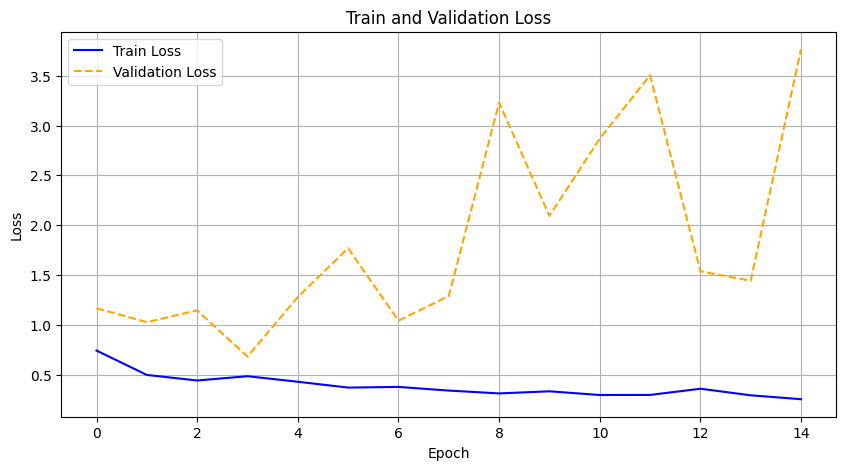

In [ ]:

# Create the plot
plt.figure(figsize=(10, 5))  # Set a single figure
plt.plot(neg_control_train_losses, label="Train Loss", color="blue", linestyle="-")
plt.plot(neg_control_val_losses, label="Validation Loss", color="orange", linestyle="--")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
_, neg_test_accuracy = validate_one_epoch(model, neg_test_loader, criterion, device)
print(f"Test Accuracy: {neg_test_accuracy:.4f}")

Test Accuracy: 0.7143


In [ ]:
# Save metrics
np.savez(
    "neg_control_metrics.npz",
    train_losses=neg_control_train_losses,
    train_accs=neg_control_train_accs,
    val_losses=neg_control_val_losses,
    val_accs=neg_control_val_accs,
    test_acc = neg_test_accuracy,
)

# Save model checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "neg_control_checkpoint.pth")

## Positive Control


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AlexNet model
model_pos = alexnet(weights=None)  # Use pretrained weights
model_pos.classifier[6] = nn.Linear(4096, 3)  # Adjust the final layer to match the number of classes (3 in this case)
model_pos = model_pos.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pos.parameters(), lr=0.001)

pos_control_train_losses, pos_control_train_accs, pos_control_val_losses, pos_control_val_accs = train(model_pos, pos_train_loader, pos_val_loader, criterion, optimizer, 15, device)

Training Iteration 100 | Loss: 0.5645
Training Iteration 200 | Loss: 0.6390
Epoch [1/15] | Train Loss: 0.7706 | Train Accuracy: 0.6518        | Val Loss: 0.5879   | Val Accuracy: 0.7480
Training Iteration 100 | Loss: 0.5597
Training Iteration 200 | Loss: 0.6349
Epoch [2/15] | Train Loss: 0.5750 | Train Accuracy: 0.7568        | Val Loss: 0.5293   | Val Accuracy: 0.7867
Training Iteration 100 | Loss: 0.4278
Training Iteration 200 | Loss: 0.4873
Epoch [3/15] | Train Loss: 0.5240 | Train Accuracy: 0.7793        | Val Loss: 0.4204   | Val Accuracy: 0.8273
Training Iteration 100 | Loss: 0.2918
Training Iteration 200 | Loss: 0.2999
Epoch [4/15] | Train Loss: 0.4834 | Train Accuracy: 0.7983        | Val Loss: 0.4348   | Val Accuracy: 0.8120
Training Iteration 100 | Loss: 0.3186
Training Iteration 200 | Loss: 0.5137
Epoch [5/15] | Train Loss: 0.4450 | Train Accuracy: 0.8119        | Val Loss: 0.3818   | Val Accuracy: 0.8443
Training Iteration 100 | Loss: 0.6999
Training Iteration 200 | Loss: 0

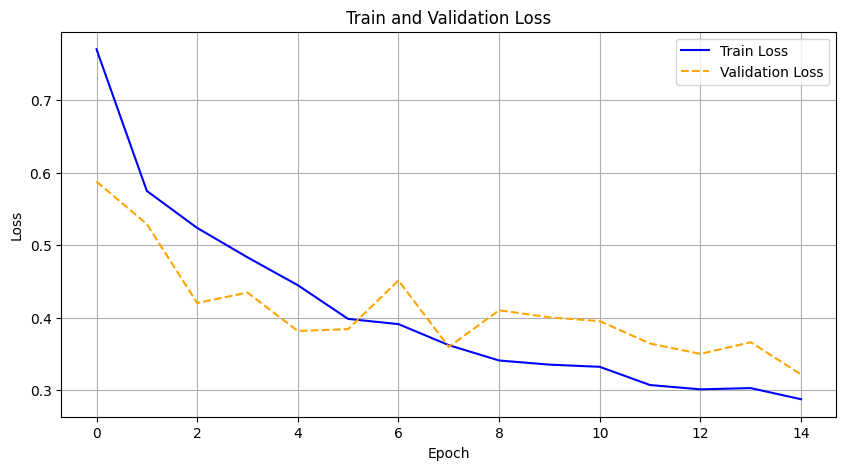

In [ ]:

# Create the plot
plt.figure(figsize=(10, 5))  # Set a single figure
plt.plot(pos_control_train_losses, label="Train Loss", color="blue", linestyle="-")
plt.plot(pos_control_val_losses, label="Validation Loss", color="orange", linestyle="--")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
_, pos_test_accuracy = validate_one_epoch(model_pos, pos_test_loader, criterion, device)
print(f"Test Accuracy: {pos_test_accuracy:.4f}")
# rounded 72.9%

Test Accuracy: 0.7285


In [ ]:
# Save metrics
np.savez(
    "pos_control_metrics.npz",
    train_losses=pos_control_train_losses,
    train_accs=pos_control_train_accs,
    val_losses=pos_control_val_losses,
    val_accs=pos_control_val_accs,
    test_acc = pos_test_accuracy,
)

# Save model checkpoint
torch.save({
    'model_state_dict': model_pos.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "pos_control_checkpoint.pth")

## Test Control Baseline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AlexNet model
model_d = alexnet(weights=None)  # Use pretrained weights
model_d.classifier[6] = nn.Linear(4096, 3)  # Adjust the final layer to match the number of classes (3 in this case)
model_d = model_d.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_d.parameters(), lr=0.001)

d_control_train_losses, d_control_train_accs, d_control_val_losses, d_control_val_accs = train(model_d, d_train_loader, d_val_loader, criterion, optimizer, 15, device)

Epoch [1/15] | Train Loss: 1.6311 | Train Accuracy: 0.7452        | Val Loss: 0.8214   | Val Accuracy: 0.7297
Epoch [2/15] | Train Loss: 0.7871 | Train Accuracy: 0.7452        | Val Loss: 0.8045   | Val Accuracy: 0.7297
Epoch [3/15] | Train Loss: 0.8003 | Train Accuracy: 0.7452        | Val Loss: 0.7945   | Val Accuracy: 0.7297
Epoch [4/15] | Train Loss: 0.7673 | Train Accuracy: 0.7452        | Val Loss: 0.7967   | Val Accuracy: 0.7297
Epoch [5/15] | Train Loss: 0.7540 | Train Accuracy: 0.7452        | Val Loss: 0.7889   | Val Accuracy: 0.7297
Epoch [6/15] | Train Loss: 0.7858 | Train Accuracy: 0.7452        | Val Loss: 0.8368   | Val Accuracy: 0.7297
Epoch [7/15] | Train Loss: 0.7763 | Train Accuracy: 0.7452        | Val Loss: 0.8093   | Val Accuracy: 0.7297
Epoch [8/15] | Train Loss: 0.7474 | Train Accuracy: 0.7452        | Val Loss: 0.8351   | Val Accuracy: 0.7297
Epoch [9/15] | Train Loss: 0.7603 | Train Accuracy: 0.7452        | Val Loss: 0.7951   | Val Accuracy: 0.7297
Epoch [10/

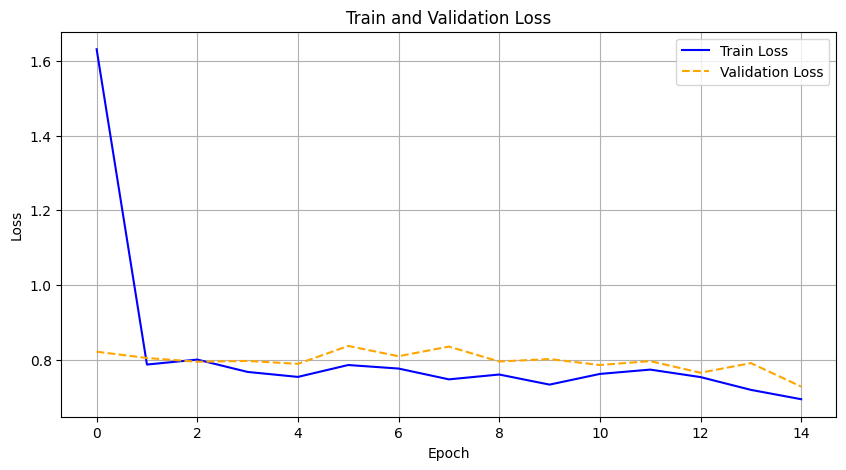

In [ ]:

# Create the plot
plt.figure(figsize=(10, 5))  # Set a single figure
plt.plot(d_control_train_losses, label="Train Loss", color="blue", linestyle="-")
plt.plot(d_control_val_losses, label="Validation Loss", color="orange", linestyle="--")

# Add labels, title, and legend
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
_, d_test_accuracy = validate_one_epoch(model_d, d_test_loader, criterion, device)
print(f"Test Accuracy: {d_test_accuracy:.4f}")

Test Accuracy: 0.6842


In [ ]:
import numpy as np
# Save metrics
np.savez(
    "d_control_metrics.npz",
    train_losses=d_control_train_losses,
    train_accs=d_control_train_accs,
    val_losses=d_control_val_losses,
    val_accs=d_control_val_accs,
    test_acc = d_test_accuracy,
)

# Save model checkpoint
torch.save({
    'model_state_dict': model_d.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "d_control_checkpoint.pth")

# Model Summary

In [ ]:
from torchvision.models import alexnet
import torch.nn as nn
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AlexNet model
model = alexnet(weights=None)  # Use pretrained weights
model.classifier[6] = nn.Linear(4096, 3)  # Adjust the final layer to match the number of classes (3 in this case)
model = model.to(device)

import torchsummary as summary
summary.summary(model, (3, 224, 224))

print(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25